# NMF topic modeling

**Topic Modeling** falls under unsupervised machine learning where the documents are processed to obtain the relative topics. It is a very important concept of the traditional Natural Processing Approach because of its potential to obtain semantic relationship between words in the document clusters.

# Non-Negative Matrix Factorization¶

Non-Negative Matrix Factorization is a statistical method to reduce the dimension of the input corpora. It uses factor analysis method to provide comparatively less weightage to the words with less coherence.

For a general case, consider we have an input matrix V of shape m x n. This method factorizes V into two matrices W and H, such that the dimension of W is m x k and that of H is n x k. For our situation, V represent the term document matrix, each row of matrix H is a word embedding and each column of the matrix W represent the weightage of each word get in each sentences ( semantic relation of words with each sentence).

Import libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
#!pip install gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 71.5 MB/s eta 0:00:00


Load dataset

In [5]:
df = pd.read_csv("/content/cnn_data_4_5.csv")

df.head()


,url,title,body,date
0,https://www.cnn.com/2020/03/23/media/japan-abe...,Japan asked the international media to change ...,"In the new system ""Canton becomes Guangzhou an...",3/24/2020
1,https://www.cnn.com/2020/03/16/perspectives/us...,The United States is still too reliant on oil,Saudi Arabia's decision to open its taps comes...,3/24/2020
2,https://www.cnn.com/2020/03/23/investing/globa...,Global stocks and US futures rise as policymak...,The promise of unlimited support for markets f...,3/24/2020
3,https://www.cnn.com/2020/03/24/economy/china-e...,China is trying to revive its economy without ...,The country where the pandemic began was almos...,3/24/2020
4,https://www.cnn.com/2020/03/24/business/bailou...,Companies that binged on buybacks now seek bai...,"Now, some of the same companies that binged on...",3/24/2020


In [6]:
print(df.shape)

(301, 4)


EDA

In [11]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
import nltk

# Contraction map
c_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}

# Compiling the contraction dict
c_re = re.compile("(%s)" % "|".join(c_dict.keys()))

# List of stop words
add_stop = ["said", "say", "...", "like", "cnn", "ad"]
stop_words = ENGLISH_STOP_WORDS.union(add_stop)

# List of punctuation
punc = list(set(string.punctuation))

# Splits words on white spaces (leaves contractions intact) and splits out
# trailing punctuation
def casual_tokenizer(text):
  tokenizer = TweetTokenizer()
  tokens = tokenizer.tokenize(text)
  return tokens

def expandContractions(text, c_re = c_re):
  def replace(match):
    return c_dict[match.group(0)]
  return c_re.sub(replace, text)

def process_text(text):
  text = casual_tokenizer(text)
  text = [each.lower() for each in text]
  text = [re.sub("[0-9]+", "", each) for each in text]

  text = [expandContractions(each, c_re = c_re) for each in text]

  text = [SnowballStemmer("english").stem(each) for each in text]

  text = [w for w in text if w not in punc]
  text = [w for w in text if w not in stop_words]
  text = [each for each in text if len(each) > 1]
  text = [each for each in text if " " not in each]
  return text

def top_words(topic, n_top_words):
  return topic.argsort()[:-n_top_words - 1:-1]

def topic_table(model, feature_names, n_top_words):
  topics = {}
  for topic_idx, topic in enumerate(model.components_):
    t = (topic_idx)
    topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

def whitespace_tokenizer(text):
  pattern = r"(?u)\b\w\w+\b"
  tokenizer_regex = RegexpTokenizer(pattern)
  tokens = tokenizer_regex.tokenize(text)
  return tokens

# Fucntion to remove duplicate words
def unique_words(text):
  ulist = []
  [ulist.append(x) for x in text if x not in ulist]
  return ulist

def word_count(text):
  return len(str(text).split(" "))

In [12]:
# Get the word count
df["word_count"] = df["body"].apply(word_count)
df["word_count"].mean()

np.float64(731.8338870431894)

In [13]:
# Process the text
df["process_text"] = df["body"].apply(process_text)

In [14]:
df.head()

,url,title,body,date,word_count,process_text
0,https://www.cnn.com/2020/03/23/media/japan-abe...,Japan asked the international media to change ...,"In the new system ""Canton becomes Guangzhou an...",3/24/2020,1075,"[new, canton, becom, guangzhou, tientsin, beco..."
1,https://www.cnn.com/2020/03/16/perspectives/us...,The United States is still too reliant on oil,Saudi Arabia's decision to open its taps comes...,3/24/2020,623,"[saudi, arabia, decis, open, tap, come, talk, ..."
2,https://www.cnn.com/2020/03/23/investing/globa...,Global stocks and US futures rise as policymak...,The promise of unlimited support for markets f...,3/24/2020,547,"[promis, unlimit, support, market, feder, rese..."
3,https://www.cnn.com/2020/03/24/economy/china-e...,China is trying to revive its economy without ...,The country where the pandemic began was almos...,3/24/2020,1478,"[countri, pandem, began, complet, shut, late, ..."
4,https://www.cnn.com/2020/03/24/business/bailou...,Companies that binged on buybacks now seek bai...,"Now, some of the same companies that binged on...",3/24/2020,1176,"[compani, bing, buyback, line, receiv, taxpaye..."


In [15]:
# Descriptive statistics for word count
df["word_count"].describe()

,word_count
count,301.000000
mean,731.833887
std,363.347371
min,93.000000
25%,473.000000
50%,682.000000
75%,966.000000
max,2502.000000


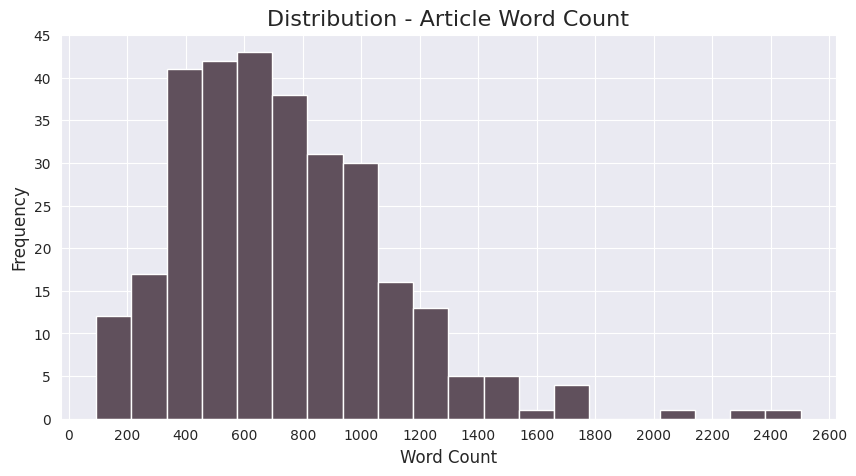

In [16]:
# Plot a histogram of the word counts
fig = plt.figure(figsize = (10, 5))
plt.hist(
    df["word_count"],
    bins = 20,
    color = '#60505C'
)

plt.title("Distribution - Article Word Count", fontsize = 16)
plt.ylabel("Frequency", fontsize = 12)
plt.xlabel("Word Count", fontsize = 12)
plt.yticks(np.arange(0, 50, 5))
plt.xticks(np.arange(0, 2700, 200))
plt.show()

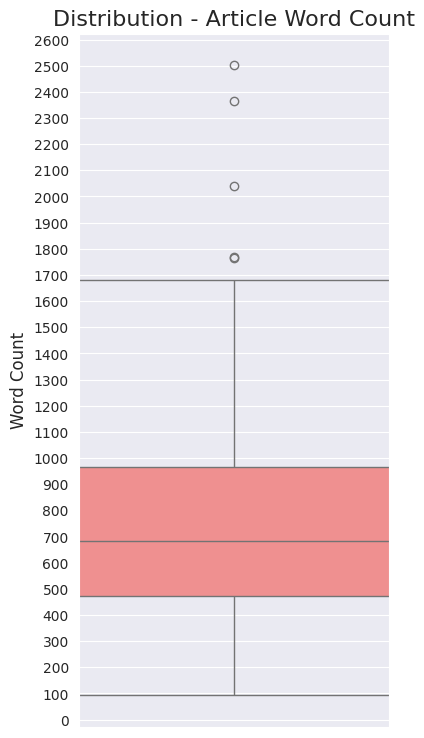

In [17]:
# Boxplot of the word count
fig = plt.figure(figsize = (4, 9))

sns.boxplot(
    df["word_count"],
    orient = "v",
    width = 5,
    color = '#ff8080'
)

plt.ylabel("Word Count", fontsize = 12)
plt.title("Distribution - Article Word Count", fontsize = 16)
plt.yticks(np.arange(0, 2700, 100))

plt.show()

Here are the top 20 words by frequency among all the articles after processing the text. ‘Company’, ‘business’, ‘people’, ‘work’ and ‘coronavirus’ are the top 5 which makes sense given the focus of the page and the time frame for when the data was scraped.

In [19]:
# Get the top 20 most common words among all the articles
p_text = df["process_text"]

# Flatten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns = ["word", "frequency"]
)

top_20

,word,frequency
0,compani,972
1,busi,750
2,peopl,718
3,work,693
4,coronavirus,564
5,week,542
6,worker,536
7,time,508
8,year,495
9,new,480


/tmp/ipython-input-3006746868.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(
/tmp/ipython-input-3006746868.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(


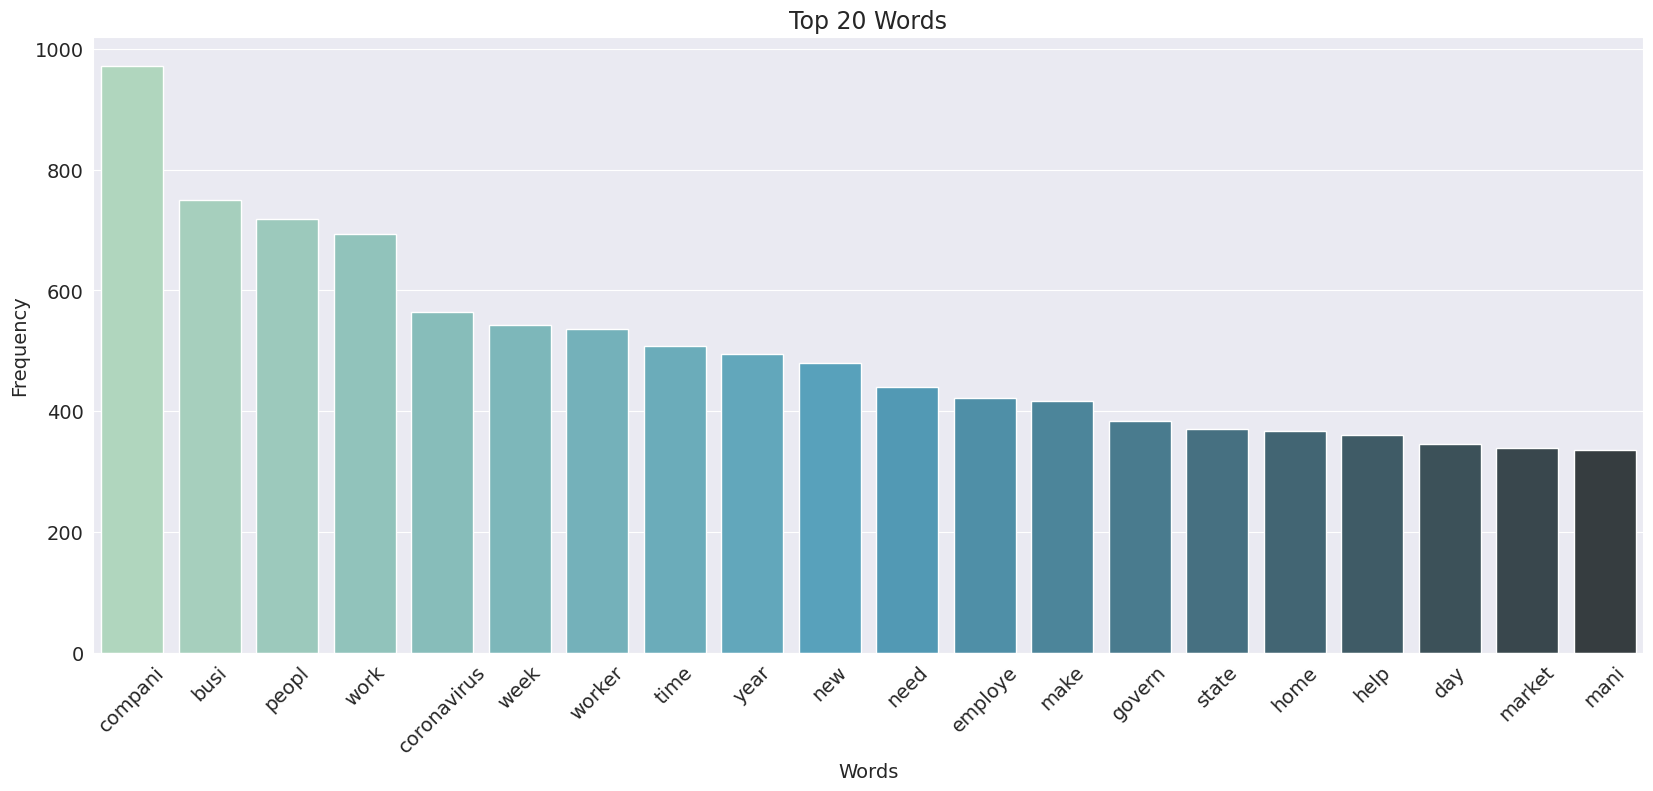

In [20]:
# plot a bar chart for the top 20 most frequency occuring words

fig = plt.figure(figsize = (20, 8))
g = sns.barplot(
    x = "word",
    y = "frequency",
    data = top_20,
    palette = "GnBu_d"
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation = 45,
    fontsize = 14
)

plt.yticks(fontsize = 14)
plt.xlabel("Words", fontsize = 14)
plt.ylabel("Frequency", fontsize = 14)
plt.title("Top 20 Words", fontsize = 17)

plt.show()

In [22]:
# Get the number of unique words after processing
num_unique_words = len(set(p_text))
num_unique_words

9127


NMF

Text Processing:



    tokenizes the text

    lower cases the text

    expands out contractions

    stems the text


In [26]:
'''
def process_text(text):
  text = casual_tokenizer(text)
  text = [each.lower() for each in text]
  text = [re.sub("[0-9]+", "", each) for each in text]

  text = [expandContractions(each, c_re = c_re) for each in text]

  text = [SnowballStemmer("english").stem(each) for each in text]

  text = [w for w in text if w not in punc]
  text = [w for w in text if w not in stop_words]
  text = [each for each in text if len(each) > 1]
  text = [each for each in text if " " not in each]
  return text
'''

'\ndef process_text(text):\n  text = casual_tokenizer(text)\n  text = [each.lower() for each in text]\n  text = [re.sub("[0-9]+", "", each) for each in text]\n\n  text = [expandContractions(each, c_re = c_re) for each in text]\n\n  text = [SnowballStemmer("english").stem(each) for each in text]\n\n  text = [w for w in text if w not in punc]\n  text = [w for w in text if w not in stop_words]\n  text = [each for each in text if len(each) > 1]\n  text = [each for each in text if " " not in each]\n  return text\n'

Feature Creation, Selection and More Reduction

ow that the text is processed we can use it to create features by turning them into numbers. There’s a few different ways to do it but in general I’ve found creating tf-idf weights out of the text works well and is computationally not very expensive (i.e runs fast).

For feature selection, we will set the ‘min_df’ to 3 which will tell the model to ignore words that appear in less than 3 of the articles. We’ll set the ‘max_df’ to .85 which will tell the model to ignore words that appear in more than 85% of the articles. This will help us eliminate words that don’t contribute positively to the model.

After processing we have a little over 9K unique words so we’ll set the max_features to only include the top 5K by term frequency across the articles for further feature reduction.

Besides just the tf-idf wights of single words, we can create tf-idf weights for n-grams (bigrams, trigrams etc.). To do that we’ll set the n_gram range to (1, 2) which will include unigrams and bigrams.

We also need to use a preprocesser to join the tokenized words as the model will tokenize everything by default.

In [24]:
texts = df["process_text"]

tfidf_vectorizer = TfidfVectorizer(
    min_df = 3,
    max_df = 0.85,
    max_features = 5000,
    ngram_range = (1, 2),
    preprocessor = " ".join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

Manual Topic Modeling

In [27]:
nmf = NMF(
    n_components = 20,
    init = "nndsvd"
).fit(tfidf)

/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


he only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are. For now we will just set it to 20 and later on we will use the coherence score to select the best number of topics automatically.

NOTE : initializing the model with ‘nndsvd’ which works best on sparse data like we have here. Everything else we’ll leave as the default which works well.

# Coherence Score

To evaluate the best number of topics, we can use the coherence score. Explaining how it’s calculated is beyond the scope of this article but in general it measures the relative distance between words within a topic.

There are a few different types of coherence score with the two most popular being c_v and u_mass. c_v is more accurate while u_mass is faster. We’ll be using c_v here which ranges from 0 to 1 with 1 being perfectly coherent topics.

I like sklearn’s implementation of NMF because it can use tf-idf weights. However, sklearn’s NMF implementation does not have a coherence score.
Therefore, we’ll use gensim to get the best number of topics with the coherence score and then use that number of topics for the sklearn implementation of NMF.

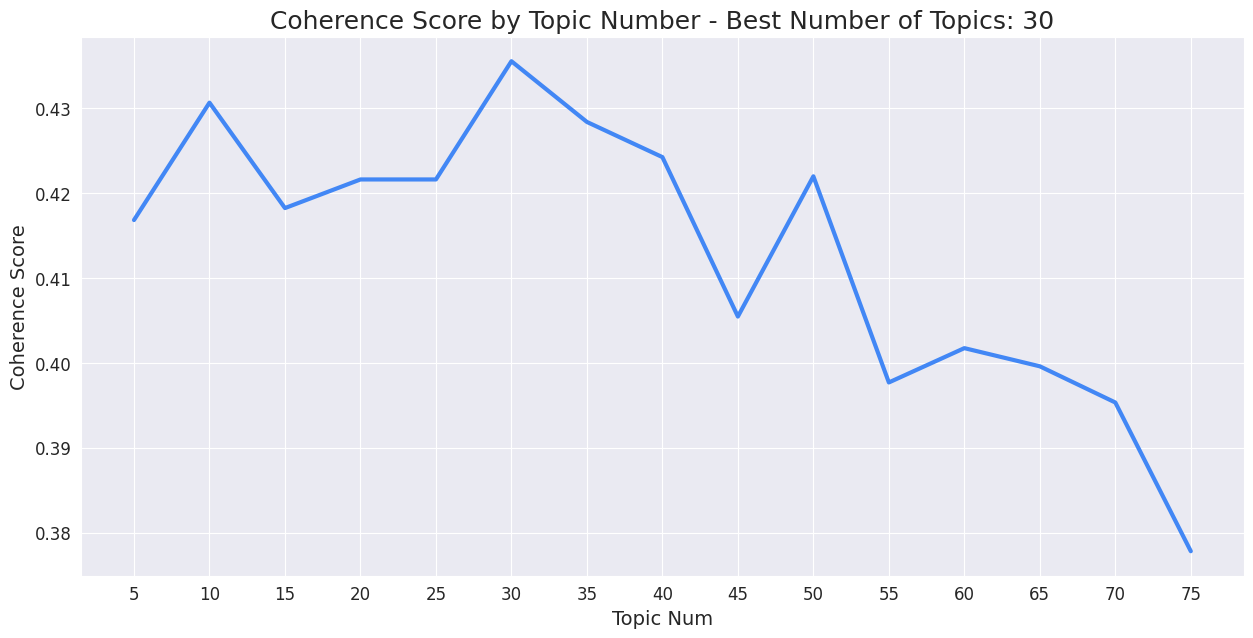

In [30]:
# Use Gensim's NMF to get the best num of topics via coherence score
text = df["process_text"]

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below = 3,
    no_above = 0.85,
    keep_n = 5000
)

# Create the bag-of-words format (list of (token_id, to ken_count))

corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numvers we want to try
topic_nums = list(np.arange(5, 75 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []
for num in topic_nums:
  nmf = Nmf(
      corpus = corpus,
      num_topics = num,
      id2word = dictionary,
      chunksize = 2000,
      passes = 5,
      kappa = .1,
      minimum_probability = 0.01,
      w_max_iter = 300,
      w_stop_condition = 0.0001,
      h_max_iter = 100,
      h_stop_condition = 0.001,
      eval_every = 10,
      normalize = True,
      random_state = 42


  )

  # Run the coherence model to get score
  cm = CoherenceModel(
      model = nmf,
      texts = texts,
      dictionary =dictionary,
      coherence = "c_v"
  )
  coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key = itemgetter(1), reverse = True)[0][0]

# Plot the resultd
fig = plt.figure(figsize = (15, 7))


plt.plot(
    topic_nums,
    coherence_scores,
    linewidth = 3,
    color = '#4287f5'

)

plt.xlabel("Topic Num", fontsize = 14)
plt.ylabel("Coherence Score", fontsize = 14)
plt.title("Coherence Score by Topic Number - Best Number of Topics: {}".format(best_num_topics), fontsize = 18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize = 12)
plt.yticks(fontsize = 12)

plt.show()

30 was the number of topics that returned the highest coherence score (.435) and it drops off pretty fast after that. Overall this is a decent score but I’m not too concerned with the actual value. The real test is going through the topics yourself to make sure they make sense for the articles.

10 topics was a close second in terms of coherence score (.432) so you can see that that could have also been selected with a different set of parameters. So, like I said, this isn’t a perfect solution as that’s a pretty wide range but it’s pretty obvious from the graph that topics between 10 to 40 will produce good results. That said, you may want to average the top 5 topic numbers, take the middle topic number in the top 5 etc. For now we’ll just go with 30.